In [ ]:
!pip install torch_geometric

In [10]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid
import torch_geometric
import numpy as np
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import random
from tqdm import tqdm

In [18]:
def load_citation_graph():
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    graph_data = dataset[0]
    return dataset, graph_data

dataset, citation_graph = load_citation_graph()
print(f"Количество статей: {citation_graph.num_nodes}")
print(f"Количество цитирований: {citation_graph.num_edges}")
print(f"Размерность признаков: {citation_graph.num_node_features}")
print(f"Количество тематик: {dataset.num_classes}")
print(f"Плотность графа: {2 * citation_graph.num_edges / (citation_graph.num_nodes * (citation_graph.num_nodes - 1)):.6f}")

Количество статей: 2708
Количество цитирований: 10556
Размерность признаков: 1433
Количество тематик: 7
Плотность графа: 0.002880


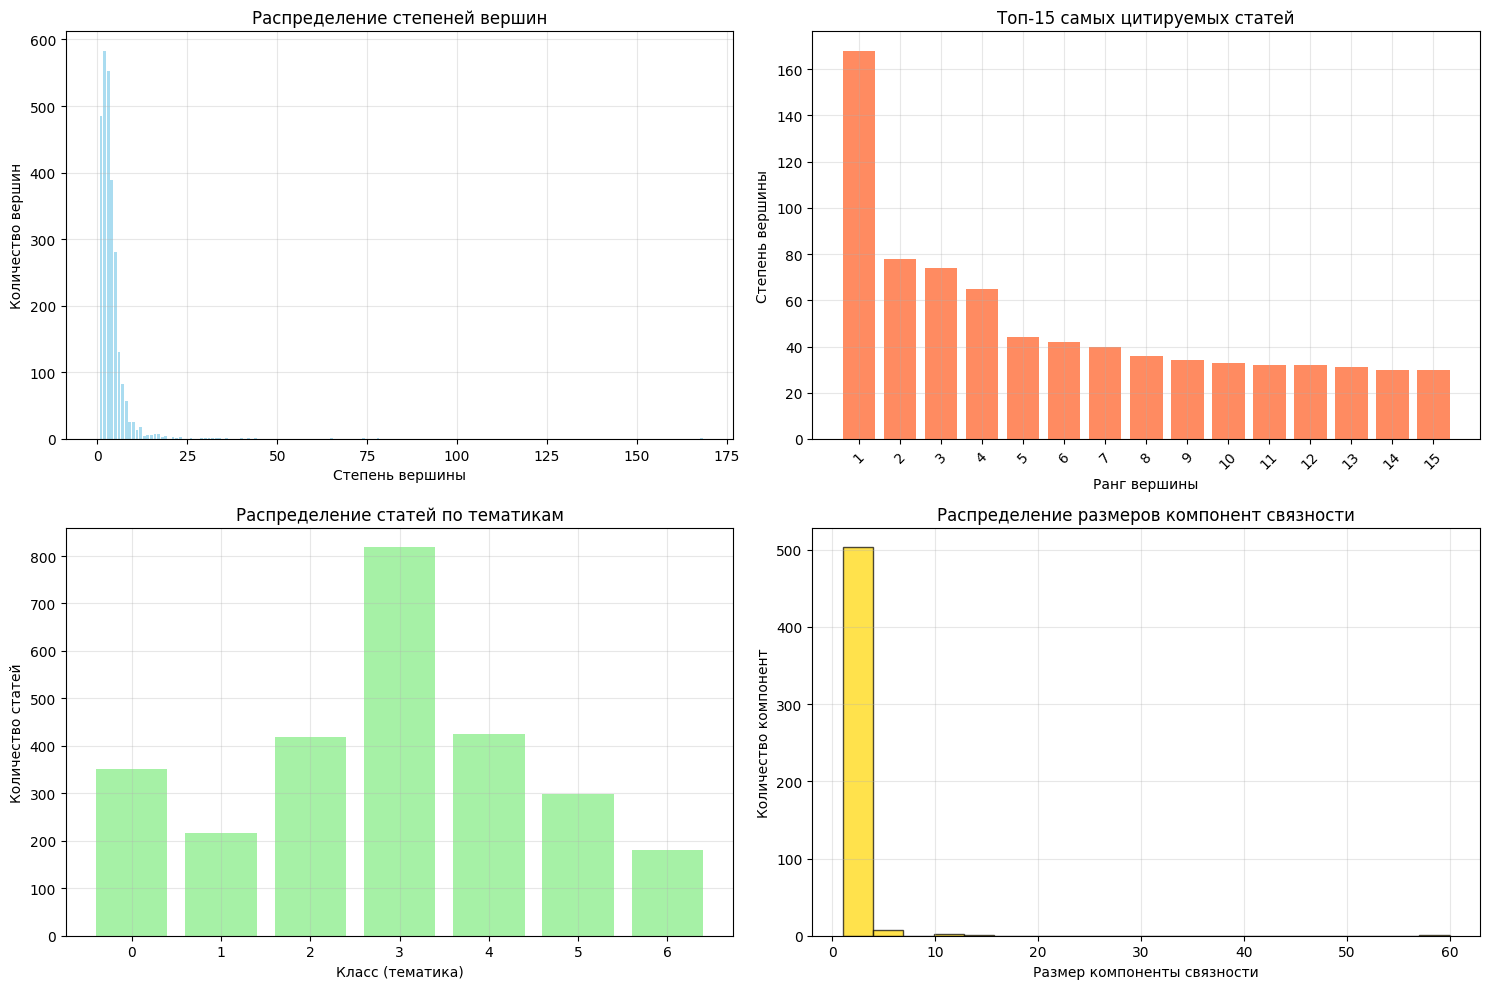

In [19]:
plt.figure(figsize=(15, 10))

degrees = torch.zeros(citation_graph.num_nodes, dtype=torch.long)
degrees = torch.scatter_add(degrees, 0, citation_graph.edge_index[0], torch.ones(citation_graph.num_edges, dtype=torch.long))

plt.subplot(2, 2, 1)
degree_counts = torch.bincount(degrees)
plt.bar(range(len(degree_counts)), degree_counts.numpy(), alpha=0.7, color='skyblue')
plt.xlabel('Степень вершины')
plt.ylabel('Количество вершин')
plt.title('Распределение степеней вершин')
plt.grid(True, alpha=0.3)

# Top-15 самых цитируемых статей
plt.subplot(2, 2, 2)
top_count = 15
top_degrees, top_indices = torch.topk(degrees, top_count)
plt.bar(range(top_count), top_degrees.numpy(), color='coral', alpha=0.9)
plt.xlabel('Ранг вершины')
plt.ylabel('Степень вершины')
plt.title(f'Топ-{top_count} самых цитируемых статей')
plt.xticks(range(top_count), [f'{i+1}' for i in range(top_count)], rotation=45)
plt.grid(True, alpha=0.3)

# Распределение по классам (тематикам)
plt.subplot(2, 2, 3)
class_counts = torch.bincount(citation_graph.y)
plt.bar(range(len(class_counts)), class_counts.numpy(), color='lightgreen', alpha=0.8)
plt.xlabel('Класс (тематика)')
plt.ylabel('Количество статей')
plt.title('Распределение статей по тематикам')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Берем подграф для визуализации
sample_nodes = torch.randperm(citation_graph.num_nodes)[:500]
sample_mask = torch.zeros(citation_graph.num_nodes, dtype=torch.bool)
sample_mask[sample_nodes] = True
sample_edge_mask = sample_mask[citation_graph.edge_index[0]] & sample_mask[citation_graph.edge_index[1]]
sample_edges = citation_graph.edge_index[:, sample_edge_mask]

G_sample = to_networkx(torch_geometric.data.Data(edge_index=sample_edges, num_nodes=500), to_undirected=True)

components = list(nx.connected_components(G_sample))
component_sizes = [len(comp) for comp in components]
plt.hist(component_sizes, bins=20, color='gold', alpha=0.7, edgecolor='black')
plt.xlabel('Размер компоненты связности')
plt.ylabel('Количество компонент')
plt.title('Распределение размеров компонент связности')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

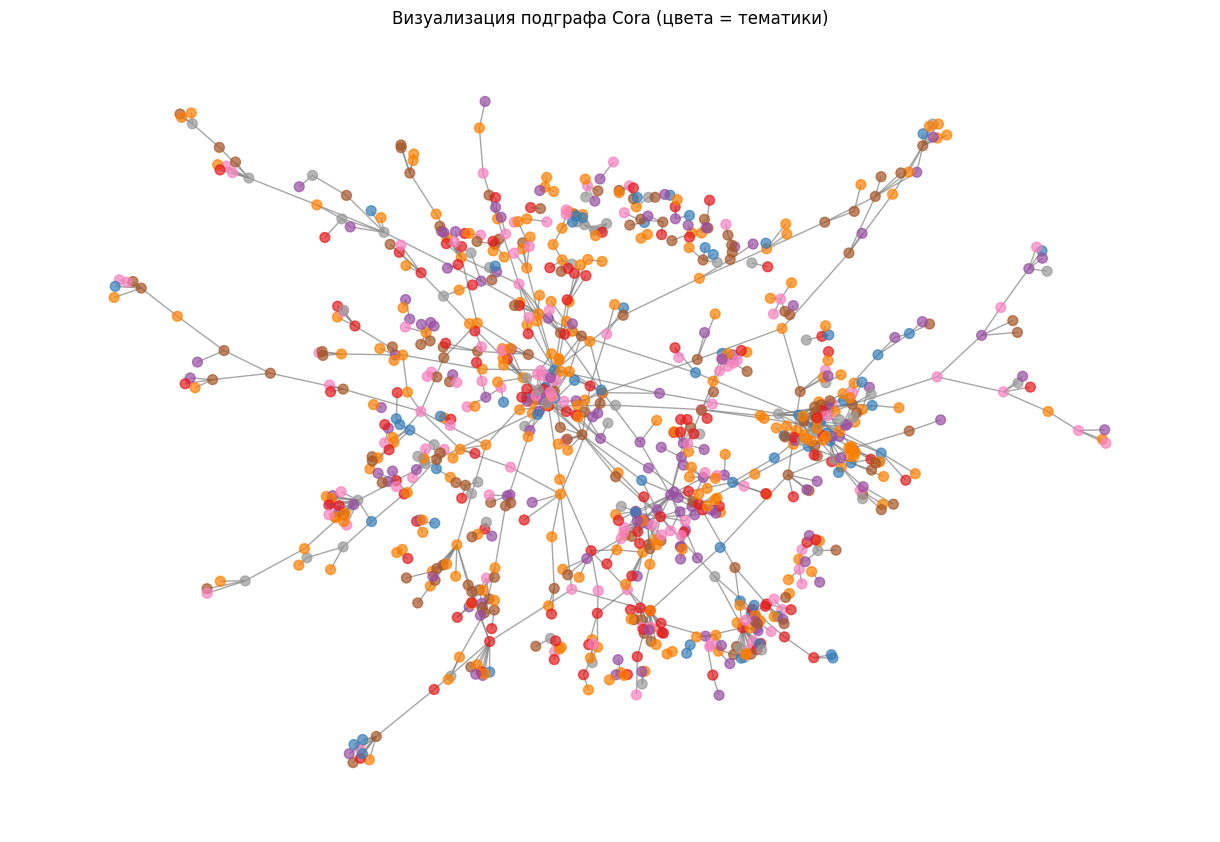

In [21]:
# Визуализация небольшого подграфа для наглядности
plt.figure(figsize=(12, 8))
G_small = to_networkx(torch_geometric.data.Data(
    edge_index=citation_graph.edge_index[:, :1000],
    y=citation_graph.y,
    num_nodes=min(200, citation_graph.num_nodes)
), to_undirected=True)

pos = nx.spring_layout(G_small, seed=42)
node_colors = [citation_graph.y[i].item() for i in range(len(G_small.nodes()))]

nx.draw(G_small, pos, node_color=node_colors, node_size=50,
        cmap=plt.cm.Set1, with_labels=False, alpha=0.7, edge_color='gray')
plt.title('Визуализация подграфа Cora (цвета = тематики)')
plt.show()

## Обучение

In [59]:
def create_training_subgraph(full_graph, node_limit=600):
    edge_index = full_graph.edge_index.numpy().T
    training_graph = nx.Graph()

    training_graph.add_edges_from([
        (u, v) for u, v in edge_index
        if u < node_limit and v < node_limit
    ])

    for node in range(min(node_limit, full_graph.num_nodes)):
        training_graph.add_node(node)

    print(f"Подграф для обучения: {training_graph.number_of_nodes()} вершин")
    print(f"Подграф для обучения: {training_graph.number_of_edges()} ребер")
    return training_graph

training_subgraph = create_training_subgraph(citation_graph, node_limit=500)

Подграф для обучения: 500 вершин
Подграф для обучения: 209 ребер


In [60]:
def generate_random_walks(graph, num_walks_per_node=10, walk_length=5):
    walks_collection = []

    for node in tqdm(graph.nodes(), desc="Генерация блужданий"):
        for walk_idx in range(num_walks_per_node):
            current_node = node
            walk_sequence = [current_node]

            for step in range(walk_length):
                neighbor_nodes = list(graph.neighbors(current_node))
                if len(neighbor_nodes) > 0:
                    next_node = int(np.random.choice(neighbor_nodes))
                    walk_sequence.append(next_node)
                    current_node = next_node
                else:
                    break

            walks_collection.append(walk_sequence)

    return walks_collection

In [61]:
def generate_biased_random_walks(graph, num_walks_per_node=10, walk_length=5,
                               return_param=1.0, inout_param=1.0):
    walks_collection = []
    node_list = list(graph.nodes())
    neighbors_dict = {node: list(graph.neighbors(node)) for node in node_list}

    for node in tqdm(node_list, desc="Node2Vec блуждания"):
        for walk_idx in range(num_walks_per_node):
            current_node = node
            walk_sequence = [current_node]

            for step in range(walk_length):
                current_neighbors = list(graph.neighbors(current_node))
                if len(current_neighbors) == 0:
                    break
                elif len(walk_sequence) == 1:
                    walk_sequence.append(random.choice(current_neighbors))
                else:
                    previous_node = walk_sequence[-2]
                    transition_weights = []

                    for neighbor in current_neighbors:
                        if neighbor == previous_node:
                            transition_weights.append(1.0 / return_param)
                        elif previous_node in neighbors_dict.get(neighbor, []):
                            transition_weights.append(1.0)
                        else:
                            transition_weights.append(1.0 / inout_param)

                    transition_weights = np.array(transition_weights)
                    probabilities = transition_weights / transition_weights.sum()

                    next_node = np.random.choice(current_neighbors, p=probabilities)
                    walk_sequence.append(next_node)

            walks_collection.append(walk_sequence)

    return walks_collection

In [63]:
def train_node_embeddings(graph, walks, embedding_dim=32, num_epochs=50,
                         negative_samples=5, learning_rate=0.01):
    num_nodes = graph.number_of_nodes()

    embedding_layer = nn.Embedding(num_nodes, embedding_dim)
    nn.init.normal_(embedding_layer.weight, mean=0.0, std=0.1)

    optimizer = torch.optim.SGD(embedding_layer.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0.0
        processed_pairs = 0

        for walk in walks:
            walk_tensor = torch.tensor(walk)
            for pos in range(len(walk) - 1):
                target_node = walk_tensor[pos]
                context_node = walk_tensor[pos + 1]

                # Positive sample loss
                target_embedding = embedding_layer(target_node)
                context_embedding = embedding_layer(context_node)
                positive_score = torch.sigmoid(torch.sum(target_embedding * context_embedding))
                positive_loss = -torch.log(positive_score + 1e-8)

                # Negative sampling loss
                negative_loss = 0.0
                for _ in range(negative_samples):
                    negative_node = random.randint(0, num_nodes - 1)
                    while negative_node == context_node or negative_node == target_node:
                        negative_node = random.randint(0, num_nodes - 1)

                    negative_embedding = embedding_layer(torch.tensor(negative_node))
                    negative_score = torch.sigmoid(torch.sum(target_embedding * negative_embedding))
                    negative_loss += -torch.log(1 - negative_score + 1e-8)

                negative_loss /= negative_samples
                total_pair_loss = positive_loss + negative_loss

                optimizer.zero_grad()
                total_pair_loss.backward()
                optimizer.step()

                total_loss += total_pair_loss.item()
                processed_pairs += 1

        if epoch % 10 == 0:
            avg_loss = total_loss / processed_pairs
            print(f"Эпоха {epoch:3d}, Средний loss: {avg_loss:.4f}")

    return embedding_layer

In [ ]:
deepwalk_walks = generate_random_walks(training_subgraph, num_walks_per_node=13, walk_length=5)
deepwalk_embeddings = train_node_embeddings(
    training_subgraph, deepwalk_walks,
    num_epochs=50, negative_samples=5
)

In [ ]:
node2vec_walks = generate_biased_random_walks(
    training_subgraph, num_walks_per_node=13, walk_length=5,
    return_param=1.0, inout_param=2.0
)
node2vec_embeddings = train_node_embeddings(
    training_subgraph, node2vec_walks,
    num_epochs=50, negative_samples=5
)

Node2Vec блуждания: 100%|██████████| 500/500 [00:00<00:00, 1491.56it/s]


Начало обучения эмбеддингов...
Эпоха   0, Средний loss: 1.2206
Эпоха  10, Средний loss: 0.7480
Эпоха  20, Средний loss: 0.7241
Эпоха  30, Средний loss: 0.6951
Эпоха  40, Средний loss: 0.6664


In [72]:
# Визуализация эмбеддингов с помощью t-SNE
def visualize_embeddings(embeddings, title):
    embedding_vectors = embeddings.weight.detach().numpy()
    reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(embedding_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                alpha=0.6, s=20, c='steelblue')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

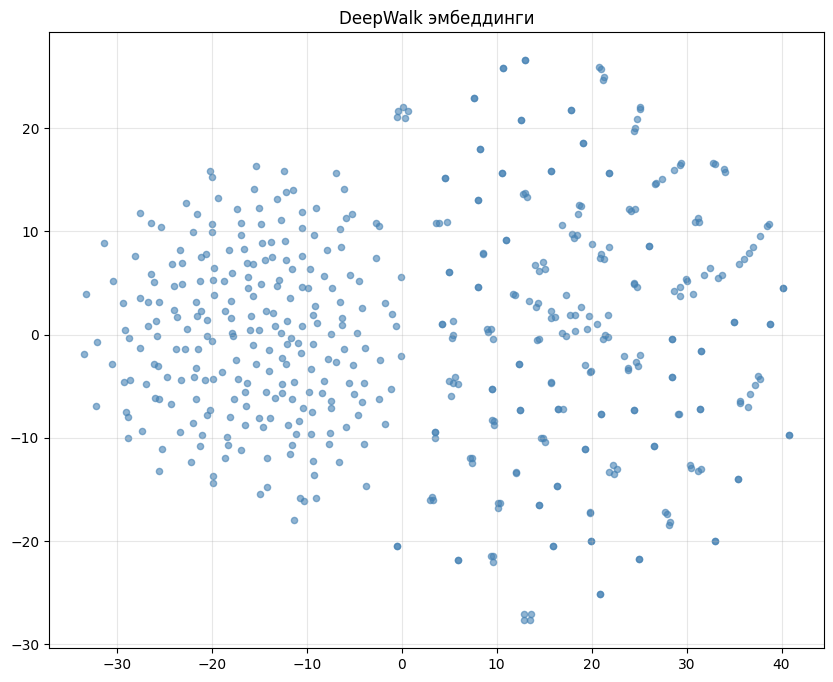

In [73]:
visualize_embeddings(deepwalk_embeddings, "DeepWalk эмбеддинги")

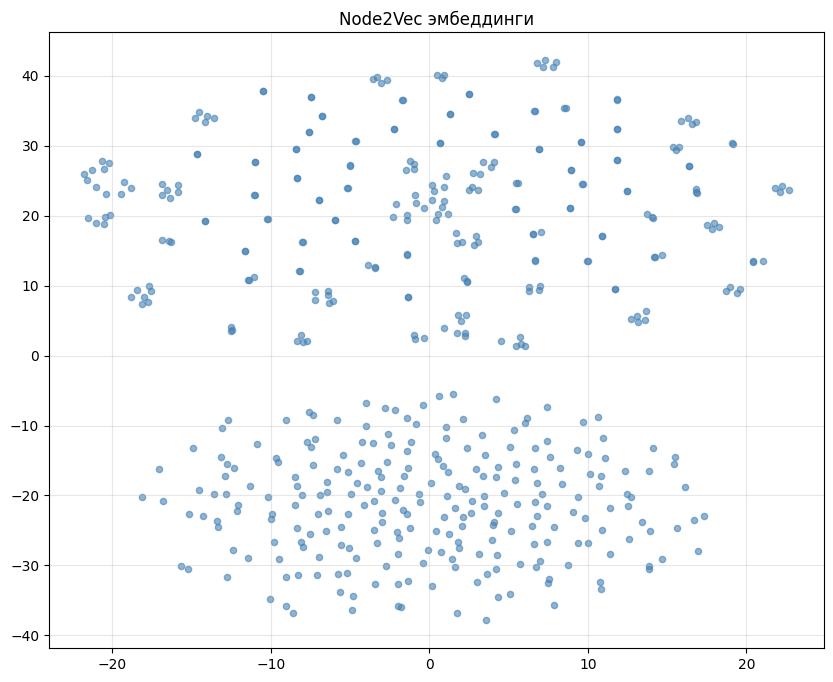

In [74]:
visualize_embeddings(node2vec_embeddings, "Node2Vec эмбеддинги")

Начали вырисовываться кластеры для обоих методов после 40 эпохи, поэтому 40-50 эпох использовал (так как еще долго обучается в целом модель)

## Переходим к классификации

In [75]:
def create_edge_features(edges, node_to_index, embedding_vectors):
    edge_features = []
    for u, v in edges:
        u_idx = node_to_index[u]
        v_idx = node_to_index[v]

        feature_vector = np.concatenate([
            embedding_vectors[u_idx],
            embedding_vectors[v_idx],
            embedding_vectors[u_idx] * embedding_vectors[v_idx]
        ])
        edge_features.append(feature_vector)
    return np.array(edge_features)

def prepare_edge_classification_data(graph, embeddings):
    # Положительные примеры - существующие ребра
    positive_edges = list(graph.edges())

    # Отрицательные примеры - случайные пары вершин без ребер
    negative_edges = []
    node_list = list(graph.nodes())

    while len(negative_edges) < len(positive_edges):
        node_u, node_v = random.sample(node_list, 2)
        if not graph.has_edge(node_u, node_v) and node_u != node_v:
            negative_edges.append((node_u, node_v))

    node_to_index = {node: idx for idx, node in enumerate(sorted(node_list))}
    embedding_vectors = embeddings.weight.detach().numpy()

    positive_features = create_edge_features(positive_edges, node_to_index, embedding_vectors)
    negative_features = create_edge_features(negative_edges, node_to_index, embedding_vectors)

    X = np.vstack([positive_features, negative_features])
    y = np.array([1] * len(positive_edges) + [0] * len(negative_edges))

    return X, y, positive_edges, negative_edges

In [78]:
def train_and_evaluate_classifiers(graph, deepwalk_emb, node2vec_emb):
    X_deepwalk, y, pos_edges, neg_edges = prepare_edge_classification_data(graph, deepwalk_emb)
    X_node2vec, _, _, _ = prepare_edge_classification_data(graph, node2vec_emb)

    X_dw_train, X_dw_test, y_train, y_test = train_test_split(
        X_deepwalk, y, test_size=0.2, random_state=42, stratify=y
    )
    X_n2v_train, X_n2v_test, _, _ = train_test_split(
        X_node2vec, y, test_size=0.2, random_state=42, stratify=y
    )
    deepwalk_classifier = GradientBoostingClassifier(
        n_estimators=100, random_state=42, max_depth=5
    )
    node2vec_classifier = GradientBoostingClassifier(
        n_estimators=100, random_state=42, max_depth=5
    )

    deepwalk_classifier.fit(X_dw_train, y_train)

    node2vec_classifier.fit(X_n2v_train, y_train)

    dw_predictions = deepwalk_classifier.predict(X_dw_test)
    n2v_predictions = node2vec_classifier.predict(X_n2v_test)

    dw_probabilities = deepwalk_classifier.predict_proba(X_dw_test)[:, 1]
    n2v_probabilities = node2vec_classifier.predict_proba(X_n2v_test)[:, 1]

    print("\n--- DeepWalk Классификатор ---")
    print(classification_report(y_test, dw_predictions))

    print("\n--- Node2Vec Классификатор ---")
    print(classification_report(y_test, n2v_predictions))

    return deepwalk_classifier, node2vec_classifier

In [80]:
deepwalk_classifier, node2vec_classifier = train_and_evaluate_classifiers(
    training_subgraph, deepwalk_embeddings, node2vec_embeddings
)


--- DeepWalk Классификатор ---
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        42
           1       0.90      0.86      0.88        42

    accuracy                           0.88        84
   macro avg       0.88      0.88      0.88        84
weighted avg       0.88      0.88      0.88        84


--- Node2Vec Классификатор ---
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        42
           1       0.89      0.79      0.84        42

    accuracy                           0.85        84
   macro avg       0.85      0.85      0.84        84
weighted avg       0.85      0.85      0.84        84



**Вывод:**

Хочу отметить, что оба метода показали высокие метрики в задаче бинарной классификации ребер графа цитирований (на подграфе):

- DeepWalk продемонстрировал f1-score 88%

- Node2Vec показал f1-score 85%

Методы эмбеддингов графа успешно решают задачу предсказания связей между научными статьями. Интересно, что простой DeepWalk оказался более эффективным, чем сложный Node2Vec с учетом структуры графа.